In [15]:
#url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/13333/862146/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619881435&Signature=i7vRkOjS3omqpv3ET%2Bt9sGegP2oKkk0kRhQ6ithuVP91%2B5ac1t0BaWIZxKbQKe0DVGIFoilvrxUdij8oyZmv4f9pOLxThnyHUZnSoY3jM%2FsiEIzyjUjb1FhKIcb7SmjHcJ8GkK3Cx2xtOBkphzH9Noy5eDHYAE%2F4emK5D3hM40PW7tkWEi0KU8ANyU0xk%2F9FlS6A1gZ7k9E%2BQ5ChCkuV0J7stLhGWbyNo28sJVDjdQQW%2BkSpfvcclmDHvv2TpNbXgerYJtuP57TXm0PqqwXKApW6brH1nEZVESmxJdN5CixzzpSGY2TikjthiheszXeRAL8aDaXUe%2Fn2KX8KUYbgzw%3D%3D&response-content-disposition=attachment%3B+filename%3Dunderstanding_cloud_organization.zip'
#import requests
#def download_file(url):
#    local_filename = '/content/drive/MyDrive/Deep/data/clouds.zip'
#    # NOTE the stream=True parameter below
#    with requests.get(url, stream=True) as r:
#        r.raise_for_status()
#        with open(local_filename, 'wb') as f:
#            for chunk in r.iter_content(chunk_size=8192): 
#                # If you have chunk encoded response uncomment if
#                # and set chunk_size parameter to None.
#                #if chunk: 
#                f.write(chunk)
#    return local_filename

#download_file(url)

In [16]:
#import zipfile
#with zipfile.ZipFile('/content/drive/MyDrive/Deep/data/clouds.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/Deep/data/')

In [17]:
!pip install segmentation-models
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0
import segmentation_models as sm

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, UpSampling2D, Conv2D, Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from pathlib import Path

In [19]:
path = '/content/drive/MyDrive/Deep/data/'
img_size = 256

tr = pd.read_csv(path + 'train.csv')
print("Number of cloud formations: {}".format(len(tr)))
tr.head()

img_names_all = tr['Image_Label'].apply(lambda x: x.split('_')[0]).unique()
print("Number of images: " + str(len(img_names_all)))

Number of cloud formations: 22184
Number of images: 5546


In [20]:
def rle2mask(rle, imgshape):

    mask = np.zeros(imgshape[0] * imgshape[1]).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    s = array[0::2]
    l = array[1::2]

    for i, start in enumerate(s):
        mask[int(start):int(start+l[i])] = 1
        
    return np.flipud(np.rot90(mask.reshape(imgshape[1], imgshape[0]), k=1))

def mask2rle(img):
    p = img.T.flatten()
    p = np.concatenate([[0], p, [0]])
    r = np.where(p[1:] != p[:-1])[0] + 1
    r[1::2] -= r[::2]
    return ' '.join(str(x) for x in r)

In [21]:
def dice_loss(y_true, y_pred):
    return 1. - (2. * K.sum(K.flatten(y_true) * K.flatten(y_pred)) + 1.) / (K.sum(K.flatten(y_true)) + K.sum(K.flatten(y_pred)) + 1.)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [22]:
new_ep = True
def keras_generator(batch_size):  
    global new_ep
    while True:   
        
        x_b = []
        y_b = []        
        for i in range(batch_size):                    
            if new_ep == True:
                img_names = tr['Image_Label'].apply(lambda x: x.split('_')[0]).unique()
                new_ep = False
            
            random_img = img_names[random.randrange(0, len(img_names))]                                       

            img = cv2.imread(path + 'dataset/train/imgs/img/'+ random_img)                      
            masks = []
            for rle in tr[tr['Image_Label'].apply(lambda x: x.split('_')[0]) == random_img]['EncodedPixels']:                
                masks.append(np.zeros((img_size, img_size)) if pd.isnull(rle) else cv2.resize(rle2mask(rle, img.shape), (img_size, img_size)))                                                    
            x_b += [cv2.resize(img, (img_size, img_size))]
            x_b += [masks] 

            img_names = img_names[img_names != random_img]   
        
        x_b = np.array(x_b)
        y_b = np.transpose(np.array(y_b), (0, 2, 3, 1))        

        yield x_b, y_b

In [23]:
sm.get_preprocessing('resnet50')
model = sm.Unet(backbone_name='resnet50', classes=4, activation='sigmoid', input_shape=(img_size, img_size, 3))

model.compile(optimizer=optimizers.Adam(lr=1e-4), loss=bce_dice_loss)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_19[0][0]          
____________________________________________________________________________________________

In [24]:
class NewEpoch(keras.callbacks.Callback):
    def on_epoch_begin (self, epoch, logs={}):
        global new_ep
        new_ep = True
EB_callback = NewEpoch()

checkpoint_filepath = '/content/drive/MyDrive/Deep/Models/pretrain_4masks/best_model_loss.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_best_only=True)

train = False
if train:
  batch_size = 16
  model.fit_generator(keras_generator(batch_size), steps_per_epoch=200, epochs=20, verbose=1, callbacks=[EB_callback, model_checkpoint_callback])
  model.save('/content/drive/MyDrive/Deep/Models/pretrain_4masks/my_model.h5')
else:
  model.load_weights('/content/drive/MyDrive/Deep/Models/pretrain_4masks/my_model.h5')

In [25]:
testfilename = 'e6388bb.jpg'
testfile = path + 'dataset/val/imgs/img/' + testfilename  
testmask = path + 'dataset/val/masks/img/' + testfilename

img = cv2.imread(testfile)
img = cv2.resize(img,(img_size,img_size))       
predict = model.predict(np.resize(np.asarray(img),(1,img_size,img_size,3)))

In [26]:
pred_rle = []
img = cv2.resize(predict[0], (525, 350))
tmp = np.copy(img)
tmp[tmp<np.mean(img)] = 0
tmp[tmp>0] = 1
for i in range(tmp.shape[-1]):
    pred_rle.append(mask2rle(tmp[:,:,i]))

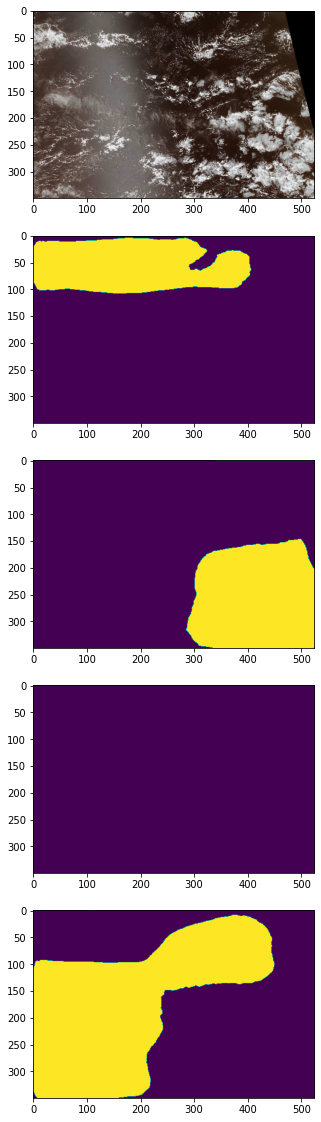

In [27]:
fig, axs = plt.subplots(5, figsize=(20, 20))
axs[0].imshow(cv2.resize(plt.imread(testfile),(525, 350)))
for i in range(4):
    axs[i+1].imshow(rle2mask(pred_rle[i], img.shape))